In [1]:
library(edgeR)

Loading required package: limma



### This Notebook runs Differential Expression Analysis from edgeR package

__input file__
* TSV file containing transcript counts for samples. 

__output file__  
* TSV file containing list of differentially expressed gene.

### Load Counts data

In [5]:
counts_data_dir = ''
Counts = read.table('rna_seq_analysis/merged_rna_counts.tsv', header = TRUE, row.names = "gene")

In [125]:
files = list.files(path='~/Documents/jupyter_notebooks/rna_seq_analysis/rna_counts/', 
                   pattern="*.counts", full.names=TRUE)

counts_df <- do.call(cbind, lapply(files, function(x) 
                            {
                                read.csv(x, sep="\t", header=FALSE, 
                                         col.names=c('gene', tail(strsplit(x, '/')[[1]], 1)), 
                                         row.names='gene')
                            }))

# Drop non-applicable rows
labels_to_drop = c("__no_feature", "__ambiguous", "__too_low_aQual", "__not_aligned", "__alignment_not_unique")
counts_df = counts_df[!(rownames(df) %in% labels_to_drop), ]
head(counts_df)


,DBY1200_0_c.counts,DBY1200_0_d.counts,DBY1200_20_b.counts,DBY1200_20_c.counts,DBY1200_40_b.counts,DBY1200_40_c.counts,FOB1_0_b.counts,FOB1_0_c.counts,FOB1_20_b.counts,FOB1_20_c.counts,⋯,SIR2_20_b.counts,SIR2_20_c.counts,SIR2_40_a.counts,SIR2_40_c.counts,UBR2_0_b.counts,UBR2_0_d.counts,UBR2_20_b.counts,UBR2_20_c.counts,UBR2_40_a.counts,UBR2_40_b.counts
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ETS1-1,2589,3018,2843,1763,5419,6547,5105,3989,3329,7601,⋯,10375,10548,15666,6460,3999,4402,5047,4542,14324,2222
ETS1-2,2581,3019,2839,1760,5407,6554,5104,3971,3331,7582,⋯,10410,10524,15617,6453,3982,4401,5042,4539,14302,2222
ETS2-1,0,2,2,0,6,6,3,2,0,1,⋯,16,17,85,33,0,2,0,1,21,0
ETS2-2,0,2,2,0,7,8,3,4,1,1,⋯,19,18,89,36,0,2,0,3,21,0
HRA1,7,28,4,3,5,6,9,9,1,4,⋯,6,8,8,10,2,14,4,7,4,1
ICR1,316,297,551,212,815,723,344,288,555,671,⋯,413,534,211,389,294,184,724,750,346,264


### Sample groupings

In [105]:
all_samples = colnames(counts_df)

age_0 = all_samples[grepl('_0_', all_samples)]

age_20 = all_samples[grepl('_20_', all_samples)]

age_40 = all_samples[grepl('_40_', all_samples)]

In [161]:
run_edgeR = function(counts_df, grp1, grp2, out_deg_file, num_deg=50){
    # Use only the required samples in grp1, grp2
    comparison_group = c(grp1, grp2)
    selected_counts_df = counts_df[comparison_group]
    dgList <- DGEList(counts=selected_counts_df, genes=rownames(selected_counts_df))
    # Filtering counts data
    countsPerMillion <- cpm(dgList)
    countCheck <- countsPerMillion > 1
    keep <- which(rowSums(countCheck) >= 2)
    dgList <- dgList[keep,]
    # Normalization
    dgList <- calcNormFactors(dgList, method="TMM")
    # Plot MDS, plotting approximate log2 fold-change between samples
    # measure of similarity between samples
    labels = gsub('.counts', '', colnames(dgList))
    plotMDS(dgList, main='Measure of similarity between samples', srt=45, labels=labels)  
    
    # Create Design matrix and run analysis
    sampleGroup <- c(rep("grp1", 8), rep("grp2", 8)) 
    
    designMat <- model.matrix(~sampleGroup)
    
    dgList <- estimateGLMCommonDisp(dgList, design=designMat)
#     plotBCV(dgList)
    
    fit <- glmFit(dgList, designMat)
    lrt <- glmLRT(fit, coef=2)
    edgeR_result <- topTags(lrt)

    deGenes <- decideTestsDGE(lrt, p=0.001)
    deGenes <- rownames(lrt)[as.logical(deGenes)]
    plotSmear(lrt, de.tags=deGenes)
    abline(h=c(-1, 1), col=2)        
    
    num_deg = 50
    top_n_deg = topTags(lrt, n=num_deg)

    write.table(data.frame(top_n_deg$table), file=out_deg_file, 
                sep='\t', row.names = FALSE, quote = FALSE)
}

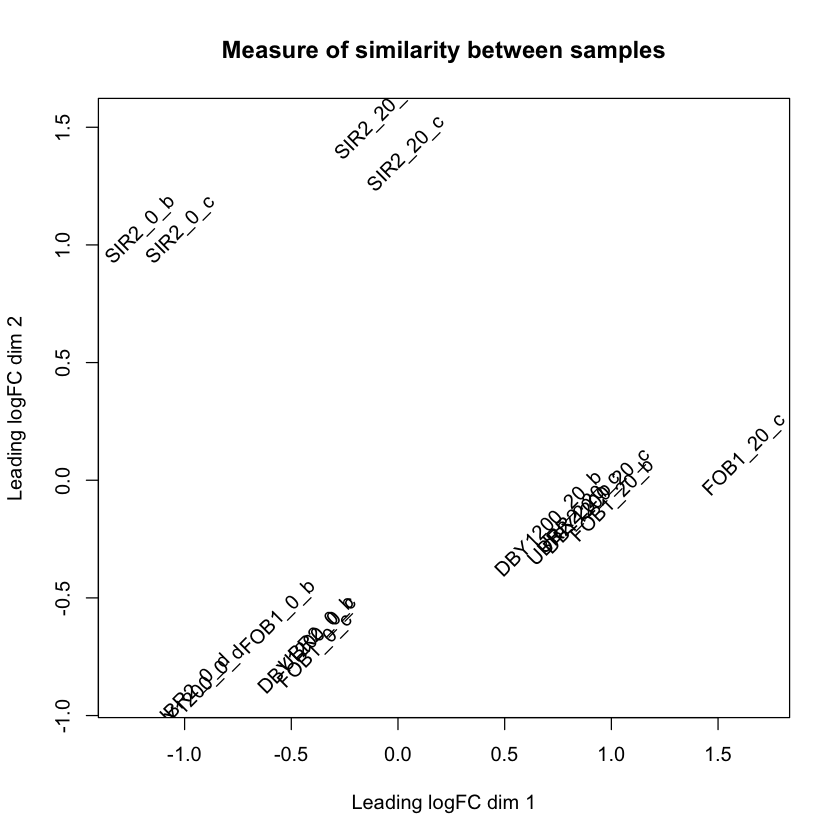

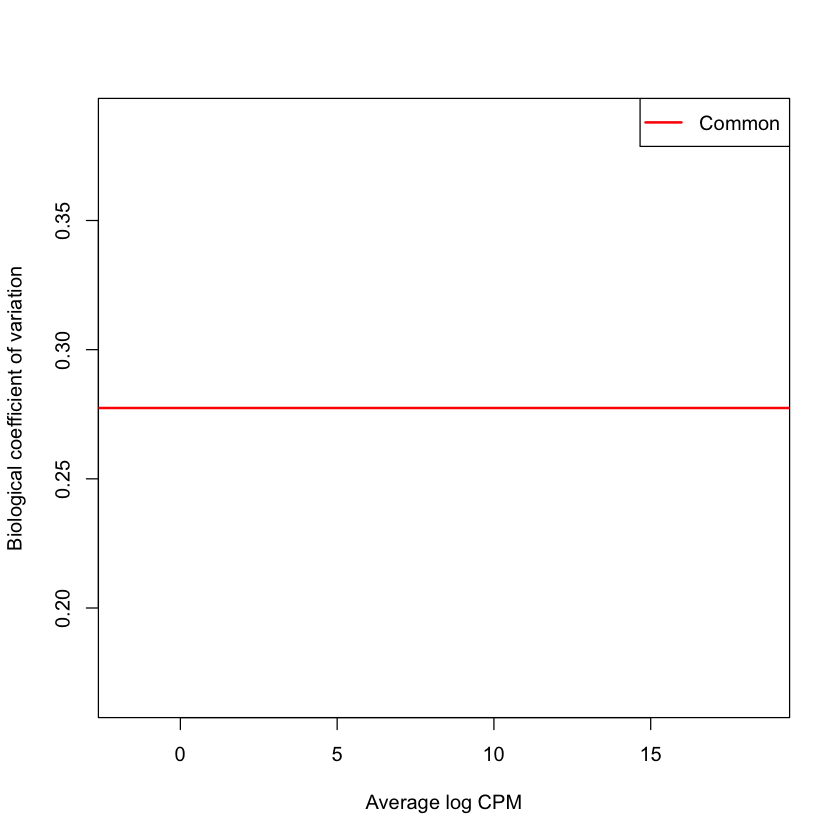

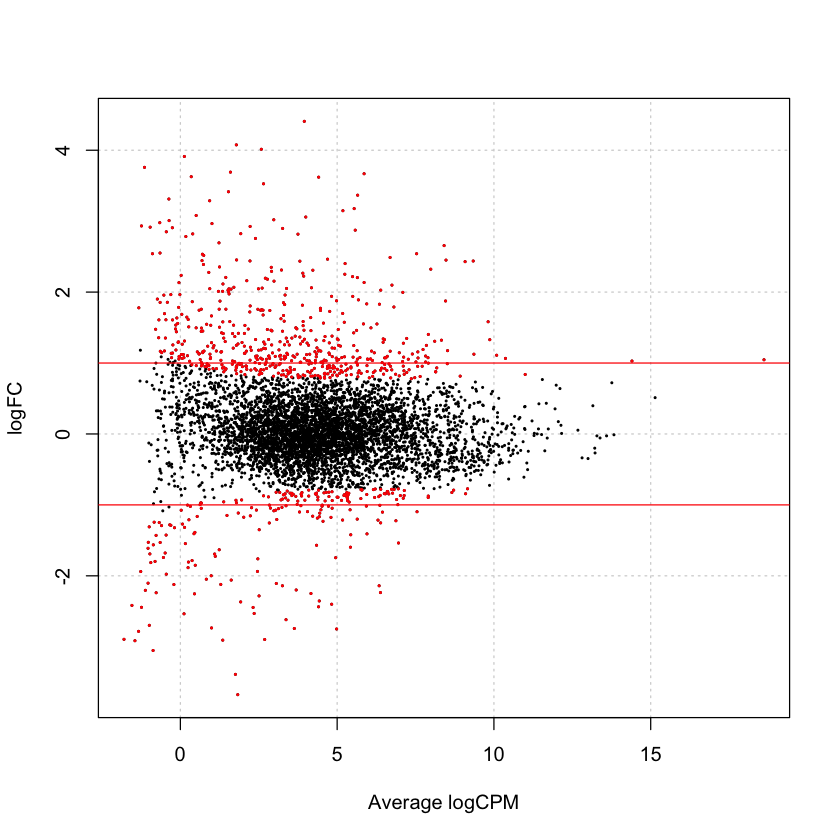

In [163]:
run_edgeR(counts_df, age_0, age_20, 'age_0_vs_age_20.tsv')

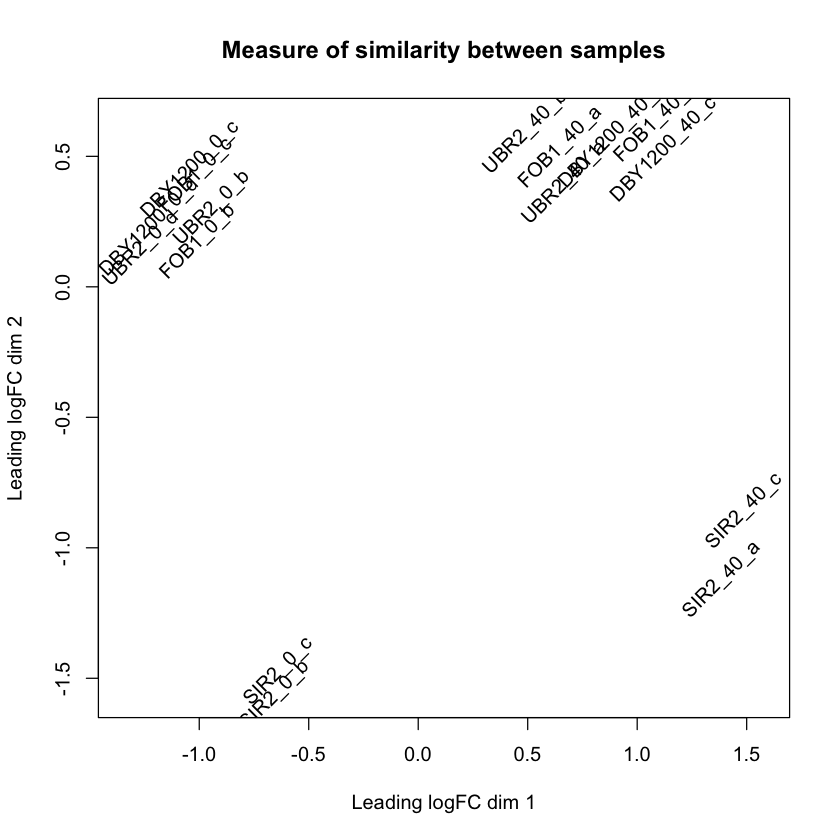

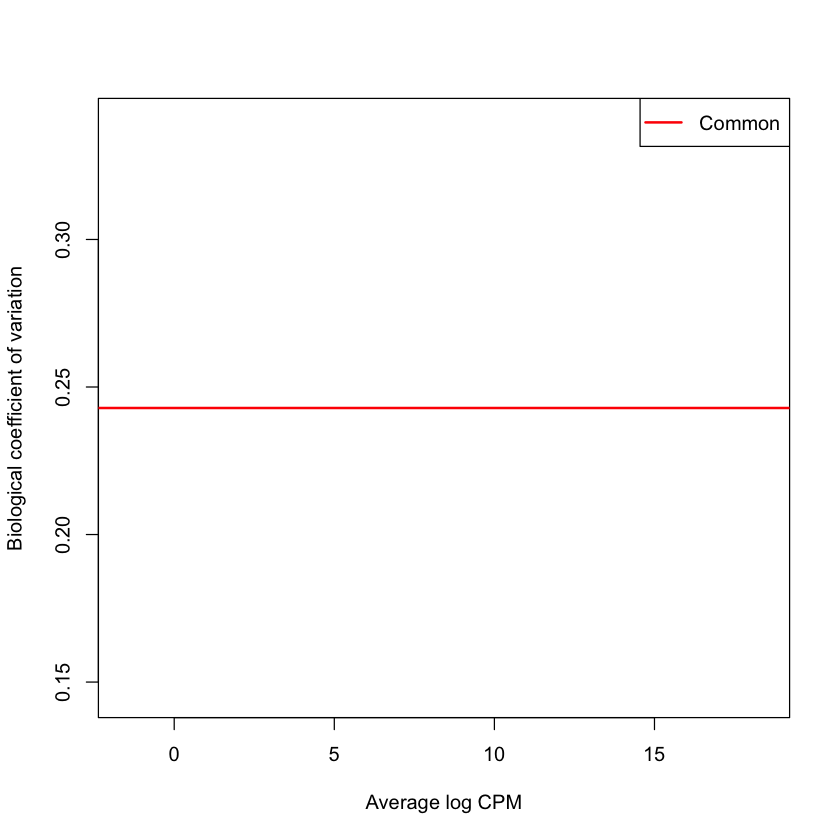

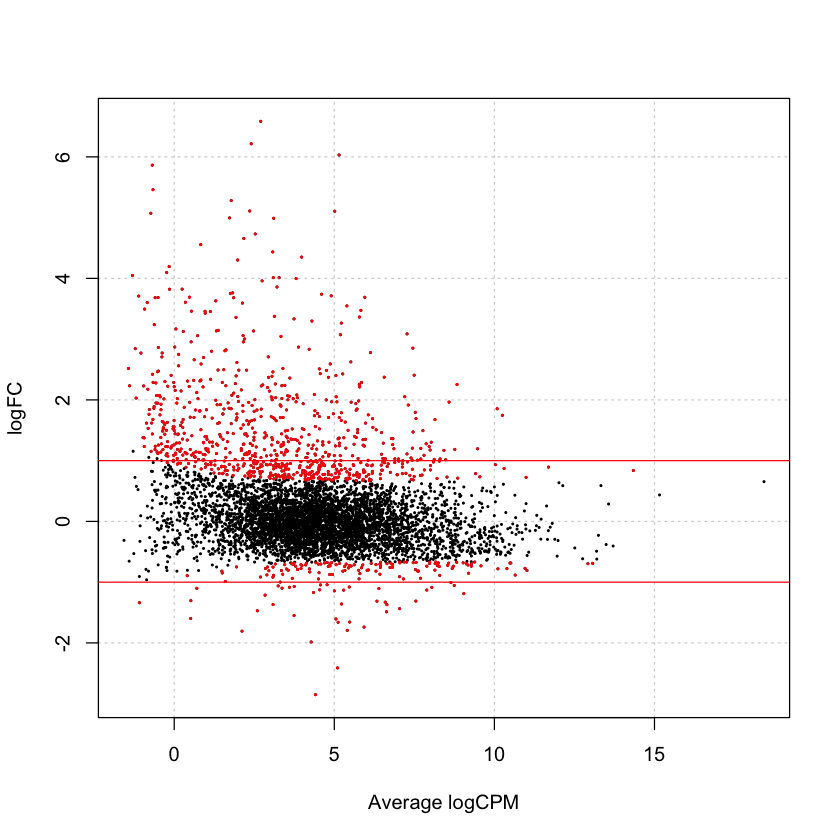

In [164]:
run_edgeR(counts_df, age_0, age_40, 'age_0_vs_age_40.tsv')

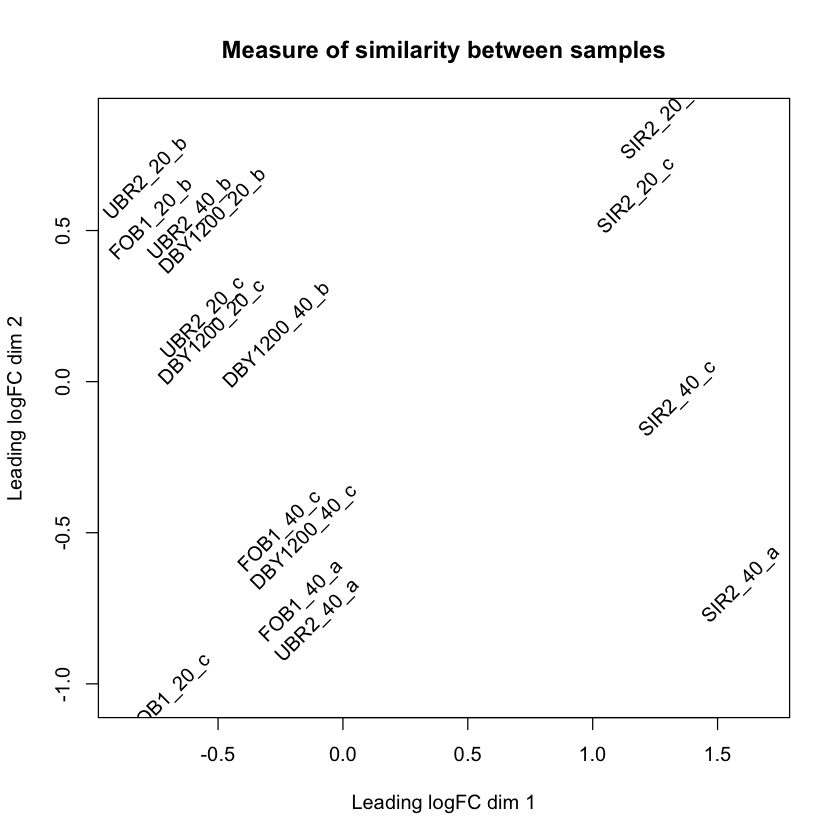

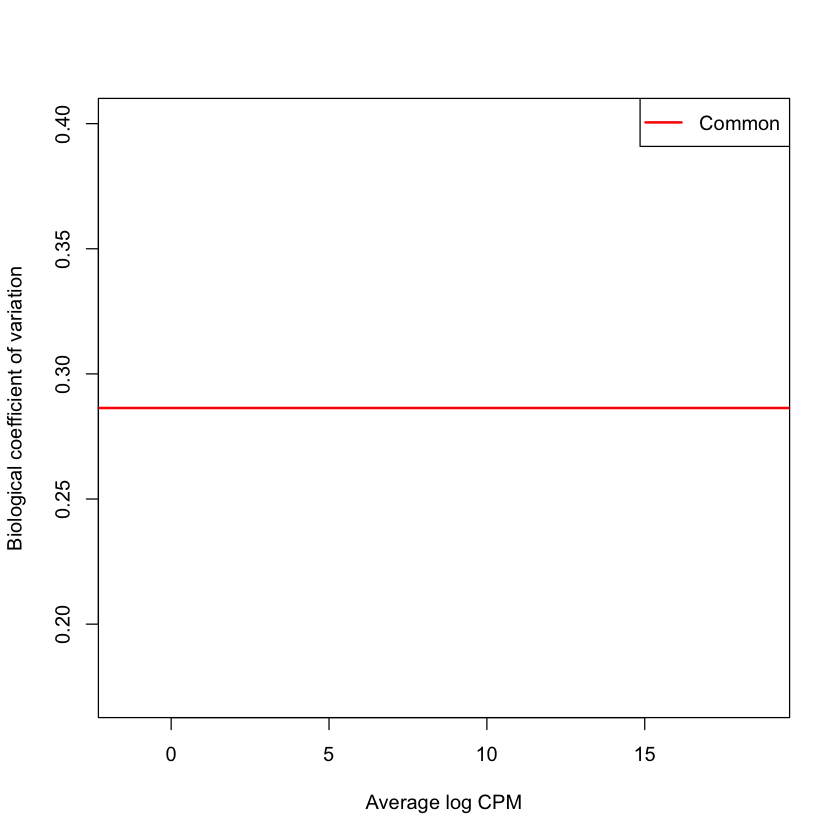

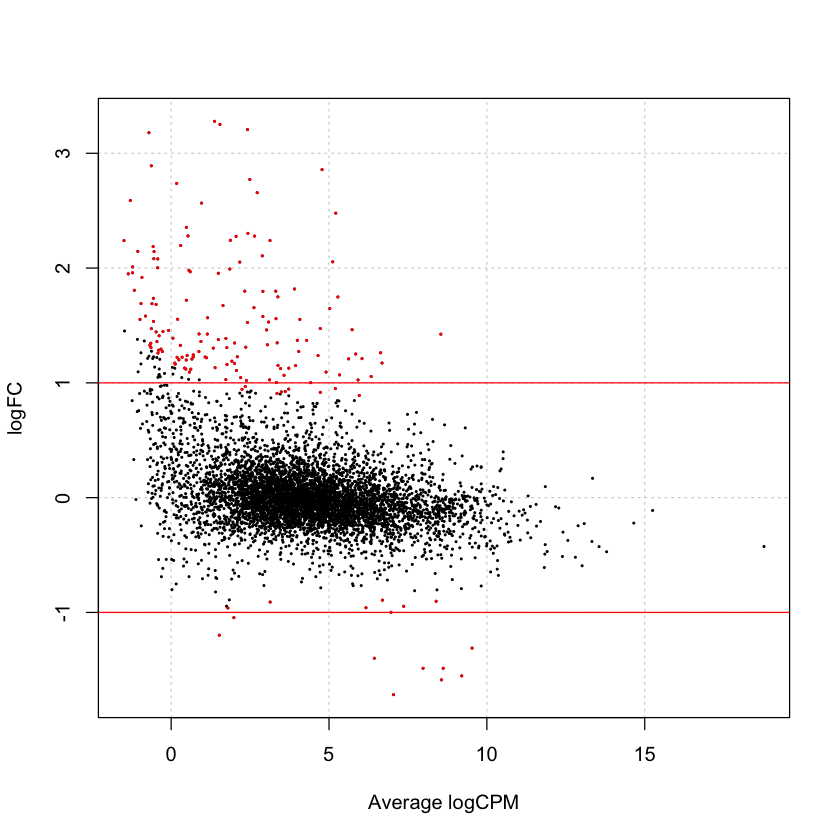

In [165]:
run_edgeR(counts_df, age_20, age_40, 'age_20_vs_age_40.tsv')